El Mostafa Hariss et Timothée Papin

## Import des données

Dans le cadre du projet sur l'apprentissage non-supervisé, nous avons choisi un sujet sur les règles d'association lors des paniers d'achats. L'objectif sera de trouver des clusters de paniers d'achats pour pouvoir faire des liens entre des produits.
Nous présenterons trois méthodes:
- Analyse en Composante Principale
- K-Means
- Approche hierarchiques
- Apriori et règle d'association avec la librairie Mlxtend

In [2]:
%matplotlib inline 
import os
import pandas as pd
import numpy as np
from mlxtend.preprocessing import TransactionEncoder

In [7]:
# Import des données csv
df0 = pd.read_csv('groceries.csv',header=None).fillna('Na')
df0.head(n=5)

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,citrus fruit,semi-finished bread,margarine,ready soups,Na,Na,Na,Na,Na,Na,...,Na,Na,Na,Na,Na,Na,Na,Na,Na,Na
1,tropical fruit,yogurt,coffee,Na,Na,Na,Na,Na,Na,Na,...,Na,Na,Na,Na,Na,Na,Na,Na,Na,Na
2,whole milk,Na,Na,Na,Na,Na,Na,Na,Na,Na,...,Na,Na,Na,Na,Na,Na,Na,Na,Na,Na
3,pip fruit,yogurt,cream cheese,meat spreads,Na,Na,Na,Na,Na,Na,...,Na,Na,Na,Na,Na,Na,Na,Na,Na,Na
4,other vegetables,whole milk,condensed milk,long life bakery product,Na,Na,Na,Na,Na,Na,...,Na,Na,Na,Na,Na,Na,Na,Na,Na,Na


In [8]:
# Transformation des variables catégorielles (produits) en variables binaires pour chaque produits (achat/pas achat)
dataset = df0.values.tolist()
te = TransactionEncoder()
te_ary = te.fit(dataset).transform(dataset).astype("int")
df = pd.DataFrame(te_ary, columns=te.columns_)
df = df.drop(columns="Na")
df.head(n=5)

,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,baby food,bags,baking powder,bathroom cleaner,beef,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


## PCA model

In [4]:
from sklearn.decomposition import PCA
x = df.values
pca = PCA()
pca.fit(x)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

Représentation des listes d'achat sur les 8 premières composantes

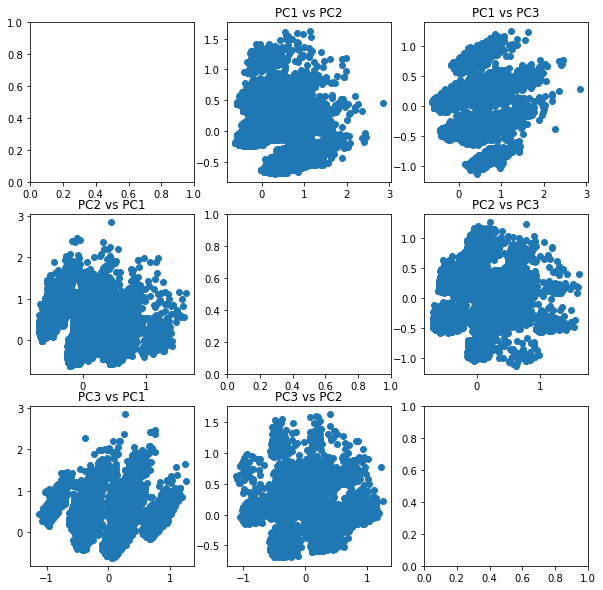

In [5]:
import matplotlib.pyplot as plt
x_pca = pca.transform(x)

fig = plt.figure(figsize=(10,10))
ax0 = fig.add_subplot(331)

ax1 = fig.add_subplot(332)
ax1.scatter(x_pca[:, 0], x_pca[:, 1])
ax1.set_title('PC1 vs PC2')

ax2 = fig.add_subplot(333)
ax2.scatter(x_pca[:, 0], x_pca[:, 2])
ax2.set_title('PC1 vs PC3')

ax3 = fig.add_subplot(334)
ax3.scatter(x_pca[:, 1], x_pca[:, 0])
ax3.set_title('PC2 vs PC1')

ax4 = fig.add_subplot(335)

ax5 = fig.add_subplot(336)
ax5.scatter(x_pca[:, 1], x_pca[:, 2])
ax5.set_title('PC2 vs PC3')

ax6 = fig.add_subplot(337)
ax6.scatter(x_pca[:, 2], x_pca[:, 0])
ax6.set_title('PC3 vs PC1')

ax7 = fig.add_subplot(338)
ax7.scatter(x_pca[:, 2], x_pca[:, 1])
ax7.set_title('PC3 vs PC2')

ax8 = fig.add_subplot(339)

On apercoit des clusters sur les axes 1 et 3 ainsi que 2 et 3. Nous allons regarder quelle est la variance expliquer par les premières composantes.

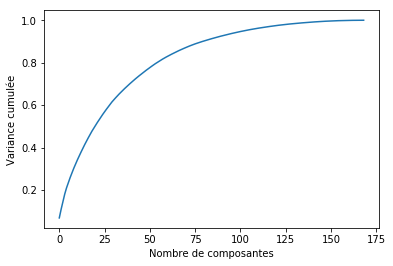

In [6]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Nombre de composantes')
plt.ylabel('Variance cumulée');

Les 55 premières composantes n'expliquent que 80% de la variance et les 80 premières n'expliquent que 90%.

Text(0.5,1,'Représentation de chaque produit sur les 2 premières composantes')

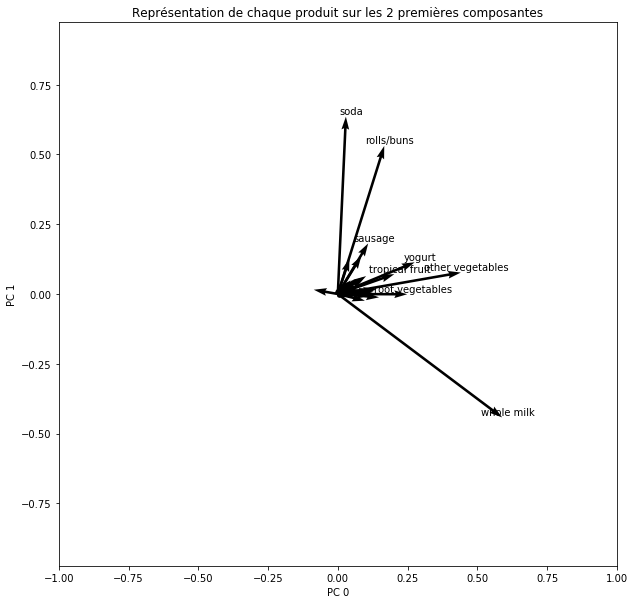

In [7]:
PCs = pca.components_
plt.figure(figsize=(10,10))
plt.quiver(np.zeros(PCs.shape[1]), np.zeros(PCs.shape[1]),
           PCs[0,:], PCs[1,:], 
           angles='xy', scale_units='xy', scale=1)

# Ajout des labels
for i,j,z in zip(PCs[1,:]+0.02, PCs[0,:]+0.02, df.columns):
    if i*i+j*j>0.05:
        plt.text(j, i, z, ha='center', va='center')

plt.axis('equal')
plt.xlim([-1.0,1.0])
plt.ylim([-1.0,1.0])

# Label axes
plt.xlabel('PC 0')
plt.ylabel('PC 1')
plt.title("Représentation de chaque produit sur les 2 premières composantes")

On constate un lien entre les légumes, les fruits et les yaourts. Ainsi qu'un lien entre le soda et les rolls/buns. On voit aussi que le lait est très décorrélé des autres achats.

## K-Means

L'approche K-means est peu performante pour les dimensions élevées. Etant donnée que nous avons déjà fait une PCA, nous allons donc réduire le nombre de variable à 55.

Nous avons essayé plusieurs nombres de clusters pour observer la stabilité des résultats et leurs pertinence. Nous nous sommes aussi basé sur les résultats de l'approche hierarchique que nous verrons un peu plus loin.

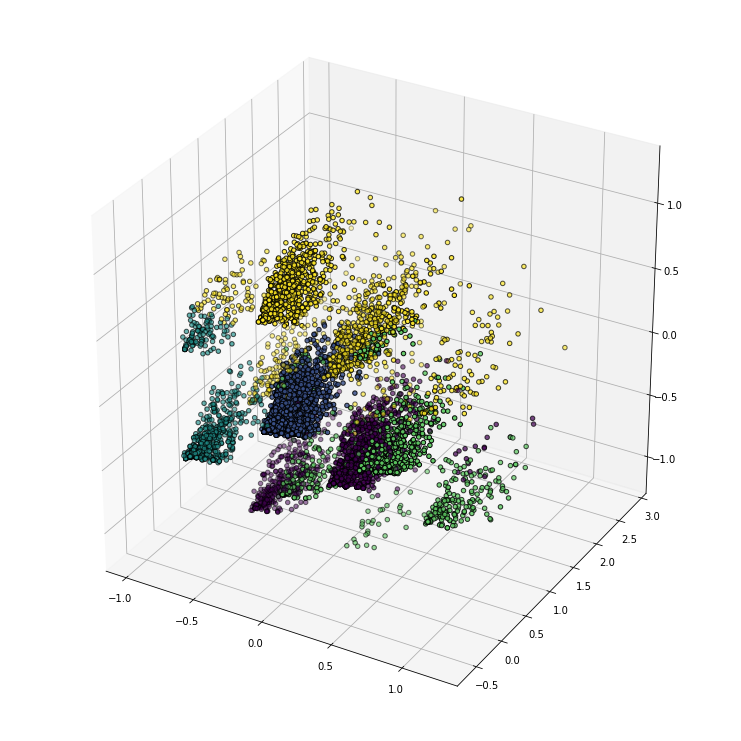

In [8]:
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

# L'approche K-means est peu performante pour les dimensions élevées,
# nous allons donc réduire le nombre de variable avec la PCA.
pca = PCA(n_components=55)
pca.fit(x)
x = pca.transform(x)

n_clusters = 5
km = KMeans(n_clusters=n_clusters)

fig = plt.figure(figsize=(10, 10))
ax = Axes3D(fig)
km.fit(x)
labels_km = km.labels_
ax.scatter(x[:, 3], x[:, 0], x[:, 2],c=labels_km.astype(np.float), edgecolor='k')

### Top 10 des produits les plus achetés

In [9]:
df.sum().sort_values(ascending=False).nlargest(10)

whole milk          2513
other vegetables    1903
rolls/buns          1809
soda                1715
yogurt              1372
bottled water       1087
root vegetables     1072
tropical fruit      1032
shopping bags        969
sausage              924
dtype: int64

### Top 10 des produits les plus achetés par cluster

In [10]:
for i in range (1,n_clusters+1):
    print('\n Top 10 des produits les plus achetés dans le cluster ' + str(i))
    print(df.loc[np.where(labels_km==i-1)].sum().sort_values(ascending=False).nlargest(5))


 Top 10 des produits les plus achetés dans le cluster 1
whole milk         1547
rolls/buns          346
yogurt              291
root vegetables     230
tropical fruit      213
dtype: int64

 Top 10 des produits les plus achetés dans le cluster 2
canned beer      471
yogurt           384
bottled water    361
shopping bags    360
bottled beer     350
dtype: int64

 Top 10 des produits les plus achetés dans le cluster 3
rolls/buns          881
sausage             119
other vegetables    108
yogurt               97
frankfurter          91
dtype: int64

 Top 10 des produits les plus achetés dans le cluster 4
soda             1465
rolls/buns        305
bottled water     242
whole milk        229
shopping bags     210
dtype: int64

 Top 10 des produits les plus achetés dans le cluster 5
other vegetables    1695
whole milk           737
root vegetables      468
yogurt               425
tropical fruit       346
dtype: int64


Dans le cas de 5 clusters, nous observons que:
- cluster 1: paniers ayant des yaourts, bieres, eau et des sac (surement pour porter les boissons)
- cluster 2: paniers ayant des sodas, rolls and sausage comme observé dans la PCA
- clusters 3 et 4: paniers ayant des yaourts, fruits et légumes comme observé dans la PCA
- cluster 5: paniers ayant essentiellement du soda

On peut conclure que les sodas, les bieres et les légumes/fruits sont achetés séparément.

### Agglomerative Clustering

In [11]:
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

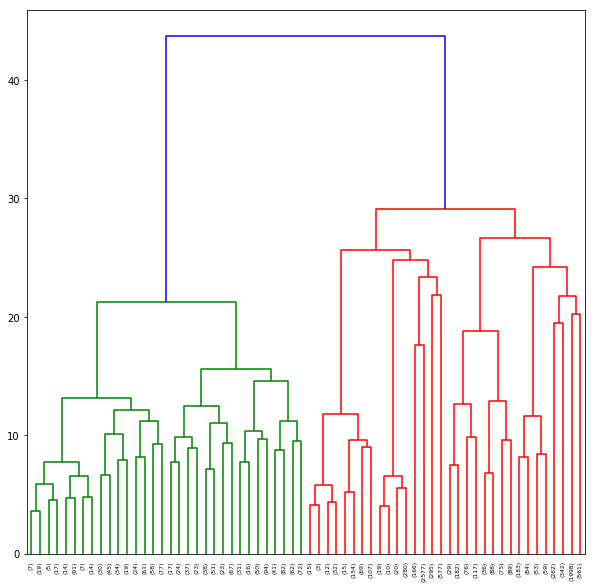

In [12]:
x = df.values #x_pca
plt.figure(figsize=(10, 10))
dendrogram = sch.dendrogram(sch.linkage(x, method='ward'),truncate_mode='level',p=5)

Le dendogramme nous permet de choisir le nombre de cluster en fonction de la distance. Pour faciliter l'affichage, nous n'avons représenté que les 5 premiers niveaux. On se rend compte que le nombre de clusters augmentent très vite d'où notre souhait de limiter le nombre de clusters à 5.

In [13]:
#n_clusters = 5
ac = AgglomerativeClustering(n_clusters=n_clusters, affinity = 'euclidean', linkage = 'ward')
labels_ac = ac.fit_predict(x)

In [14]:
for i in range (1,n_clusters+1):
    print('\n Top 10 des produits les plus achetés dans le cluster ' + str(i))
    print(df.loc[np.where(labels_ac==i-1)].sum().sort_values(ascending=False).nlargest(5))


 Top 10 des produits les plus achetés dans le cluster 1
soda             813
canned beer      550
bottled water    467
whole milk       442
rolls/buns       418
dtype: int64

 Top 10 des produits les plus achetés dans le cluster 2
other vegetables    962
whole milk          632
yogurt              420
root vegetables     416
rolls/buns          325
dtype: int64

 Top 10 des produits les plus achetés dans le cluster 3
whole milk          1179
yogurt               721
other vegetables     602
tropical fruit       535
root vegetables      489
dtype: int64

 Top 10 des produits les plus achetés dans le cluster 4
rolls/buns       546
sausage          244
whole milk       205
soda             160
shopping bags    125
dtype: int64

 Top 10 des produits les plus achetés dans le cluster 5
bottled beer     378
bottled water     72
soda              70
liquor            63
whole milk        55
dtype: int64


Dans le cas de 5 clusters, nous observons que:
- cluster 1 et 5: paniers ayant des boissons (sodas, bieres, eau et lait)
- cluster 2: paniers ayant des légumes, lait et yaourt
- cluster 3: paniers ayant des légumes, lait et yaourt plus des fruits
- cluster 4: paniers diversifiés (rolls, sausage, lait et soda)

On peut conclure que les boissons et les légumes/fruits sont achetés séparément ce qui est proche de ce que l'on a observé avec les K-Means.

### Comparaison K-means et AC

Text(0,0.5,'Agglomerative clustering')

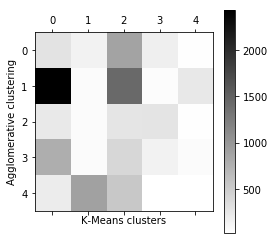

In [15]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(labels_km, labels_ac)

plt.matshow(mat, cmap=plt.cm.gray_r) # imshow
plt.colorbar()

plt.xlabel('K-Means clusters')
plt.ylabel('Agglomerative clustering')


On obtient une certaine concordance entre les clusters obtenues par les 2 méthodes:
- cluster KM 1 <=> cluster AC 2 et 4 (cluster des boissons)
- cluster KM 2 <=> cluster AC 5 (cluster des yaourt, légumes et fruit)
- clusters KM 3 et 4 n'ont pas vraiment d'équivalent
- cluster KM 5 <=> cluster AC 2 (cluster des boissons)

Les approches K-Means et Hierarchique mettent en évidence que les boissons et les légumes/fruits sont achetés séparément.

## Pour aller un peu plus loin

La librairie Mlxtend permet de résoudre des problématiques d'apriori et d'association.

In [47]:
from mlxtend.frequent_patterns import apriori
frequent_itemsets = apriori(df, min_support=0.05, use_colnames=True)
frequent_itemsets

,support,itemsets
0,0.052466,(beef)
1,0.080529,(bottled beer)
2,0.110524,(bottled water)
3,0.064870,(brown bread)
4,0.055414,(butter)
5,0.077682,(canned beer)
6,0.082766,(citrus fruit)
7,0.058058,(coffee)
8,0.053279,(curd)
9,0.063447,(domestic eggs)


La fonction d'apriori nous renvoie les aliments ayant une occurence d'au moins 5%. Seulement 3 couples d'aliments apparaissent dans le top 30:
- lait et légumes
- lait et rolls/buns
- lait et yaourt

In [53]:
from mlxtend.frequent_patterns import association_rules
association_rules(frequent_itemsets, metric="confidence", min_threshold=0.2)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(whole milk),(other vegetables),0.255516,0.193493,0.074835,0.292877,1.513634,0.025394,1.140548
1,(other vegetables),(whole milk),0.193493,0.255516,0.074835,0.386758,1.513634,0.025394,1.214013
2,(whole milk),(rolls/buns),0.255516,0.183935,0.056634,0.221647,1.205032,0.009636,1.048452
3,(rolls/buns),(whole milk),0.183935,0.255516,0.056634,0.307905,1.205032,0.009636,1.075696
4,(whole milk),(yogurt),0.255516,0.139502,0.056024,0.219260,1.571735,0.020379,1.102157
5,(yogurt),(whole milk),0.139502,0.255516,0.056024,0.401603,1.571735,0.020379,1.244132


En définissant un threshold à 20% sur l'indice de confiance (confidence), nous obtenons 5 associations. Les 5 associations sont cohérentes avec les clusters établis précédemment.